In [1]:
import datasets as ds 
import biofaces as bf
from illum_models import *
import utils

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

29152021e-02 6.88687434e-03
  6.70852745e-03 1.74071680e-02 8.04617246e-02 1.47059250e-01
  1.37223844e-01 1.23414966e-01 9.28292735e-02 8.09755997e-02
  5.85517658e-02 4.68361070e-02 3.05403571e-02 1.38124221e-02
  2.55139599e-03 4.91914367e-04 1.40109127e-04 6.98923684e-05
  5.03818051e-05]
 [3.14570726e-04 2.49866226e-04 2.90489522e-04 2.52496246e-04
  2.75307400e-04 2.74911425e-04 4.15342123e-04 1.06847418e-03
  2.08900048e-03 3.35127270e-03 6.12093571e-03 1.00407466e-02
  1.59463694e-02 2.16784865e-02 2.18967564e-02 2.20250114e-02
  2.07147060e-02 2.00301779e-02 5.72220826e-02 1.28662372e-01
  1.34410968e-01 9.41643189e-02 1.22281279e-01 1.26285153e-01
  1.04676413e-01 5.41545554e-02 1.64749674e-02 8.32779579e-03
  3.22441966e-03 1.33252225e-03 1.03332289e-03 5.40622151e-04
  1.74286805e-04]
 [4.73093877e-05 1.39485883e-03 7.08993985e-04 6.78451091e-04
  4.06513693e-04 3.45020481e-04 4.21659180e-04 9.64997173e-04
  1.33970809e-03 1.44298915e-03 2.32352426e-03 4.12839892e-03
  8.52

In [2]:
#To run this line, change the line below to include the path to the directory where the celebA dataset is.
celebA_data = ds.image_dataset(filepath='/home/sasha/Desktop/bioFaces/data/celebA_img_norm_mask_light.h5', filepath_shade='/home/sasha/Desktop/bioFaces/data/celebA_shade.h5')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

bioFinder = bf.BioFaces(illuminants=(illA,illD,illF), 
                        camera_spectral_sensitivities=spec_senstivity,
                        skin_reflectance=skin_reflect_arr,
                        t_mat=t_mat,
                        batch_size=64)
bioFinder.to(device)

#Loss function
loss_func = bf.bioFacesLoss()

# loss_weights = [1e-3,1e-4,1e-5,1e-5]
#Optimizer
optimizer = torch.optim.Adam(bioFinder.parameters(), lr=1e-5, weight_decay=1e-2)

Using cuda device


In [4]:
# Epochs
n_epochs = 50
batch = 1

bioFinder.train()
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in celebA_data:
        images, mask, shade = data
        images = torch.tensor(images).to(device)
        mask = np.reshape(mask, (64,1,64,64))
        mask   = torch.tensor(mask).to(device)
        shade = np.reshape(shade, (64,1,64,64))
        shade  = torch.tensor(shade).to(device)

        optimizer.zero_grad()
        rgb_imgs, camera_specs, diffuse, specular, _, _ = bioFinder(images)
        # loss = loss_weights[0]*appearence_loss(rgb_imgs*mask, images*mask) 
        # loss += loss_weights[1]*camera_loss(torch.square(camera_specs)) 
        # loss += loss_weights[2]*specular_sparse_loss(specular)
        # loss += loss_weights[3]*
        loss = loss_func(images, mask, shade, rgb_imgs, camera_specs, specular, diffuse)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()#*images.size(0)
        print("\rbatch: " + str(batch) + ", loss: " + str(loss.item()), end =" ")
        batch+=1
          
    batch = 0
    train_loss = train_loss/len(celebA_data)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/home/sasha/.local/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sasha/Desktop/bioFaces/biofaces_old.py:151: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  illum_weights   = self.softmax(illum_weights)
/home/sasha/.local/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
batch: 753, loss: 106.32617950439453 Epoch: 1 	Training Loss: 56.425749
batch: 752, loss: 86.2627182006836 Epoch: 2 	Training Loss: 6.352383
batch: 752, loss: 80.18119812011719 Epoch: 3 	Training Loss: 6.132034
batch: 752, loss: 3

KeyboardInterrupt: 

In [4]:
# Load Pretrained Model
bioFinder = bf.BioFaces(illuminants=(illA,illD,illF), 
                        camera_spectral_sensitivities=spec_senstivity,
                        skin_reflectance=skin_reflect_arr,
                        t_mat=t_mat,
                        batch_size=64)
bioFinder.load_state_dict(torch.load("models/skin_seg_spherical2"))
bioFinder.eval()
bioFinder.to(device)

BioFaces(
  (encoder): Scale_Bio_Camera(
    (imgEncoder): ConvAutoEncoderArrayDecoder(
      (encoder): ConvAutoEncoder(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batchNorm4): BatchNorm2d(256, eps=1e-05, momentum=0.

/home/sasha/.local/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sasha/Desktop/health_sensor_final/health_sensor_laptop_env_rgb_only/training_only/biofaces_training/biofaces.py:151: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  illum_weights   = self.softmax(illum_weights)
/home/sasha/.local/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
(64, 64, 3) [158.86865234 124.83813477 108.59277344] 40.789106788668846
(64, 64, 3) [159.14233398 124.78369141 108.28466797] 40.82665136243752
(64, 64, 1) [0

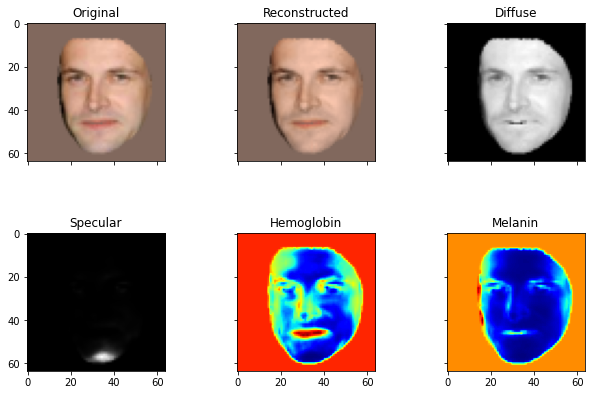

(64, 64, 3) [170.03198242 127.45800781 100.00390625] 48.17053611126001
(64, 64, 3) [169.83178711 127.5703125  100.19433594] 47.824203107685676
(64, 64, 1) [0.42488348] 0.47281265
(64, 64, 1) [0.00034161] 0.0018646094
(64, 64, 1) [0.41272122] 0.11569154
(64, 64, 1) [0.37452468] 0.16212384


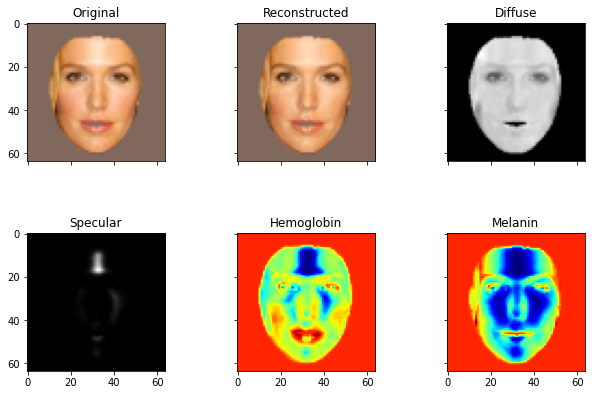

(64, 64, 3) [169.0480957  134.48828125 119.52099609] 46.05217095875595
(64, 64, 3) [169.44824219 134.48901367 118.33251953] 46.01011034978917
(64, 64, 1) [0.39798042] 0.43062794
(64, 64, 1) [0.00156702] 0.005584275
(64, 64, 1) [0.33061808] 0.18985897
(64, 64, 1) [0.29258126] 0.22265393


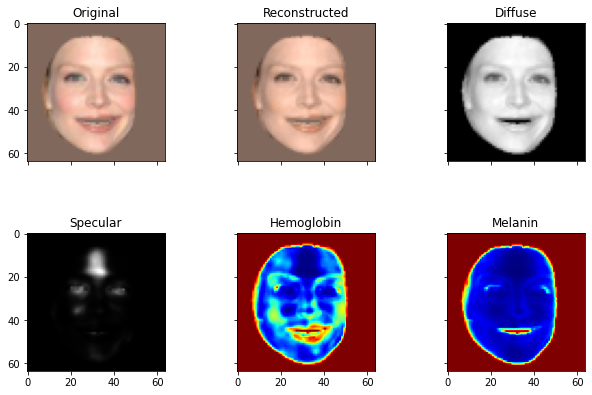

(64, 64, 3) [144.84985352 106.03808594  87.69238281] 30.982034083093392
(64, 64, 3) [144.69238281 105.95141602  87.62255859] 30.656236905743157
(64, 64, 1) [0.2948957] 0.35738948
(64, 64, 1) [0.00023969] 0.0011807545
(64, 64, 1) [0.44003525] 0.08741682
(64, 64, 1) [0.39628658] 0.13364318


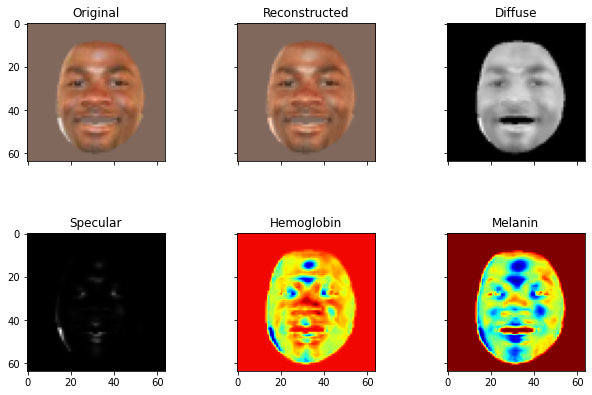

(64, 64, 3) [152.15942383 131.99829102 123.62524414] 56.530933787575215
(64, 64, 3) [152.42456055 130.69897461 123.49169922] 56.5555574337589
(64, 64, 1) [0.29840076] 0.34844828
(64, 64, 1) [0.04851814] 0.068980895
(64, 64, 1) [0.28772962] 0.22651707
(64, 64, 1) [0.29880697] 0.22396599


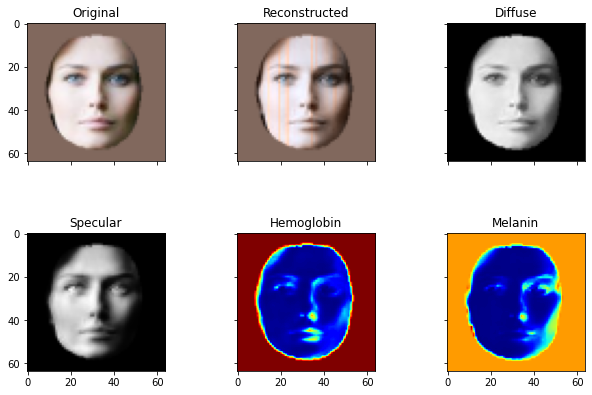

(64, 64, 3) [158.93945312 128.36328125 107.72802734] 46.11114023528781
(64, 64, 3) [159.16772461 128.45605469 107.3762207 ] 46.19411096218657
(64, 64, 1) [0.35802048] 0.43356645
(64, 64, 1) [0.00059019] 0.002365617
(64, 64, 1) [0.39997664] 0.14773603
(64, 64, 1) [0.33755106] 0.19974034


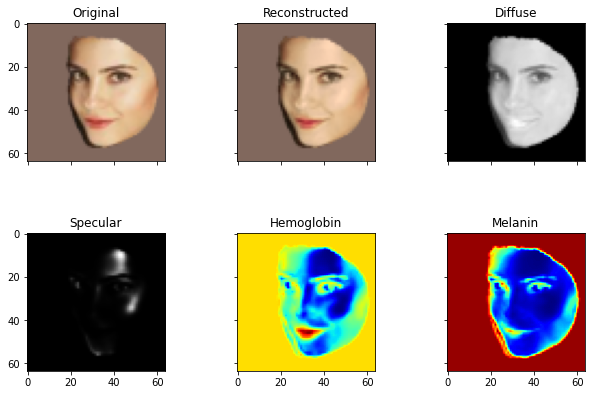

(64, 64, 3) [179.66479492 112.90625     69.21020508] 61.5106803903463
(64, 64, 3) [178.63305664 112.37451172  70.54125977] 59.98728756983684
(64, 64, 1) [0.7152772] 0.8151445
(64, 64, 1) [4.6629288e-05] 0.0005438776
(64, 64, 1) [0.45456603] 0.09930016
(64, 64, 1) [0.5009608] 0.039775003


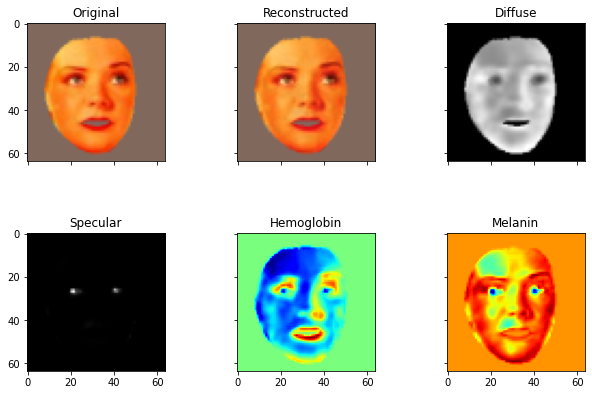

(64, 64, 3) [135.8515625  114.75146484 105.87866211] 35.39482040173961
(64, 64, 3) [136.67919922 113.86816406 105.76660156] 35.855324314763585
(64, 64, 1) [0.23176986] 0.27838355
(64, 64, 1) [0.03188497] 0.051985264
(64, 64, 1) [0.31174058] 0.21315828
(64, 64, 1) [0.3063607] 0.22212674


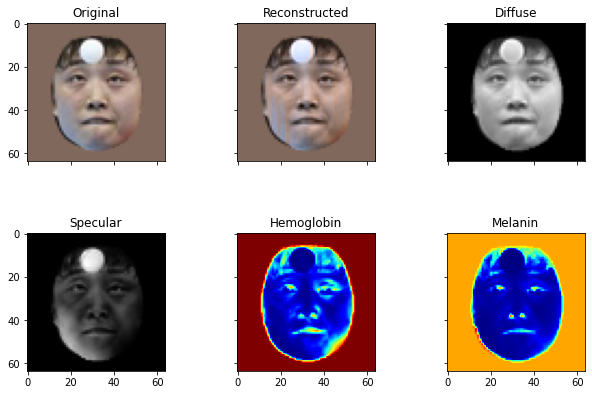

(64, 64, 3) [159.5234375  126.20776367 110.16333008] 44.78226113625334
(64, 64, 3) [159.96191406 126.22583008 110.00634766] 44.81785834791784
(64, 64, 1) [0.349919] 0.41423482
(64, 64, 1) [0.00624096] 0.018756013
(64, 64, 1) [0.38639107] 0.16197567
(64, 64, 1) [0.3360095] 0.20535456


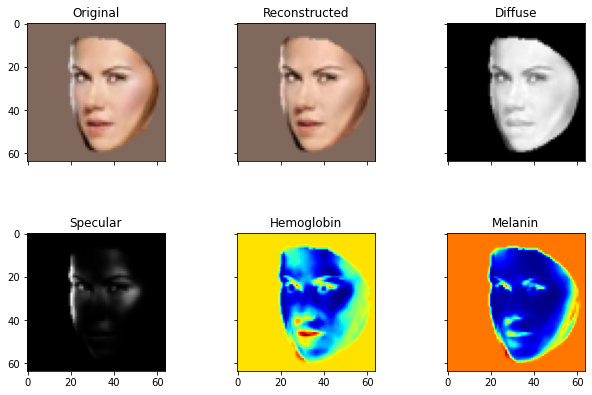

(64, 64, 3) [162.00561523 125.4519043  106.21972656] 41.61520562977819
(64, 64, 3) [161.90649414 125.59594727 106.18652344] 41.48374422164137
(64, 64, 1) [0.3543695] 0.4174984
(64, 64, 1) [2.9095814e-05] 9.3982555e-05
(64, 64, 1) [0.39120704] 0.1422329
(64, 64, 1) [0.34571457] 0.18956508


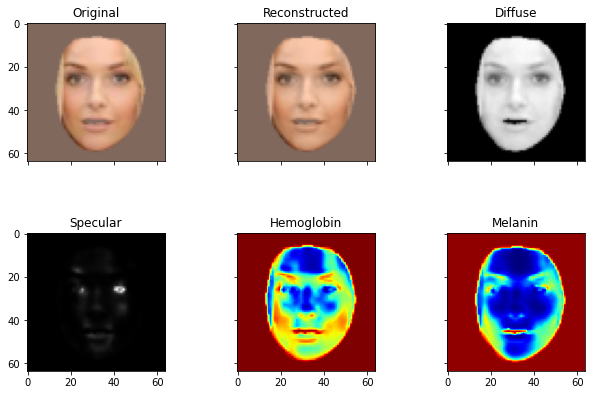

(64, 64, 3) [140.81982422  96.22045898  81.7746582 ] 34.8888315913988
(64, 64, 3) [140.68066406  96.36401367  81.46704102] 34.654186423157206
(64, 64, 1) [0.2724176] 0.3671269
(64, 64, 1) [0.00031996] 0.002417394
(64, 64, 1) [0.49235845] 0.0735858
(64, 64, 1) [0.42212144] 0.11260879


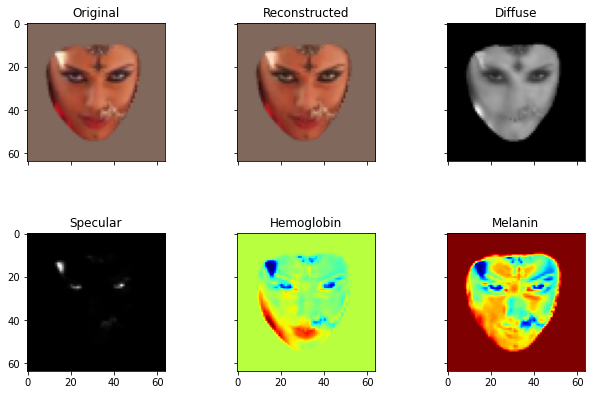

(64, 64, 3) [136.94311523 101.14599609  88.203125  ] 40.235333791540874
(64, 64, 3) [136.66259766 101.62011719  87.49829102] 40.351945119009855
(64, 64, 1) [0.28768125] 0.32737523
(64, 64, 1) [0.00041546] 0.0014273261
(64, 64, 1) [0.40268722] 0.12779844
(64, 64, 1) [0.3531015] 0.18338165


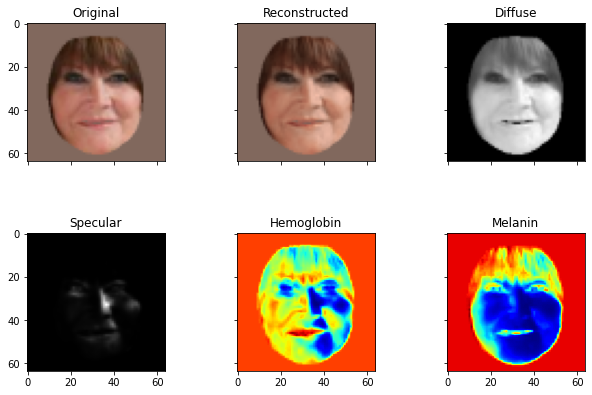

(64, 64, 3) [146.91772461 103.75366211  86.0871582 ] 40.1624887747567
(64, 64, 3) [146.70117188 103.77099609  86.09423828] 40.07481607844565
(64, 64, 1) [0.3339804] 0.37192243
(64, 64, 1) [5.5205295e-05] 0.00019850285
(64, 64, 1) [0.4369393] 0.08424447
(64, 64, 1) [0.37747929] 0.14630277


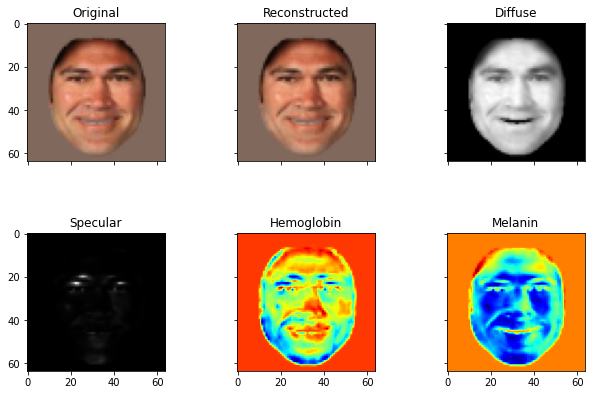

(64, 64, 3) [158.1953125  125.01733398  96.9921875 ] 46.63738011705992
(64, 64, 3) [158.04296875 125.10083008  97.17578125] 46.64420691324354
(64, 64, 1) [0.37573862] 0.44621336
(64, 64, 1) [2.4726247e-05] 7.9492456e-05
(64, 64, 1) [0.4253233] 0.0919981
(64, 64, 1) [0.3813821] 0.14786103


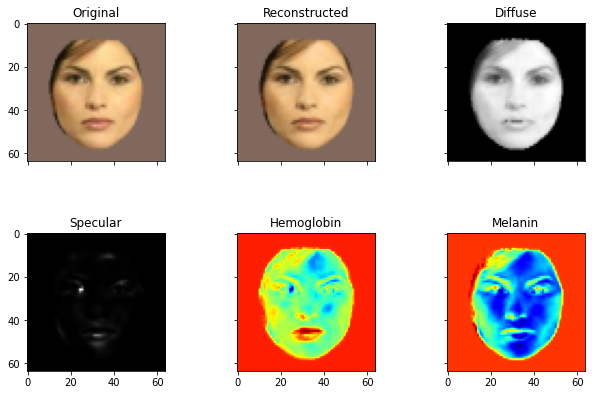

(64, 64, 3) [141.66088867 112.67529297 105.78857422] 35.88797510297948
(64, 64, 3) [142.12719727 113.71484375 104.36767578] 36.10293550945605
(64, 64, 1) [0.25256038] 0.3008247
(64, 64, 1) [0.02830828] 0.044408698
(64, 64, 1) [0.33915728] 0.19571619
(64, 64, 1) [0.30954134] 0.2201043


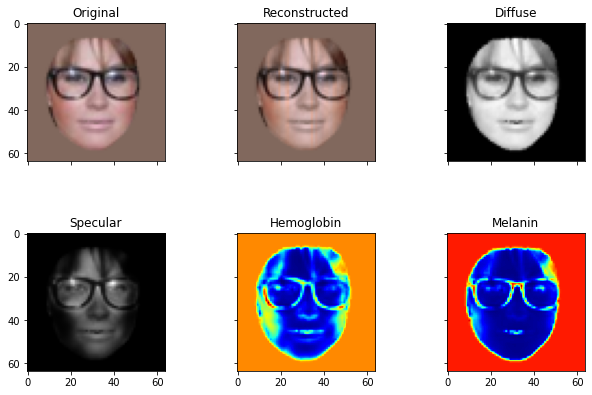

(64, 64, 3) [157.22363281 121.29492188 105.95922852] 39.1050386359559
(64, 64, 3) [157.43505859 121.57763672 105.41918945] 39.02100330449167
(64, 64, 1) [0.33885995] 0.39283988
(64, 64, 1) [0.00136746] 0.0069887345
(64, 64, 1) [0.3924004] 0.14196073
(64, 64, 1) [0.33224988] 0.19901197


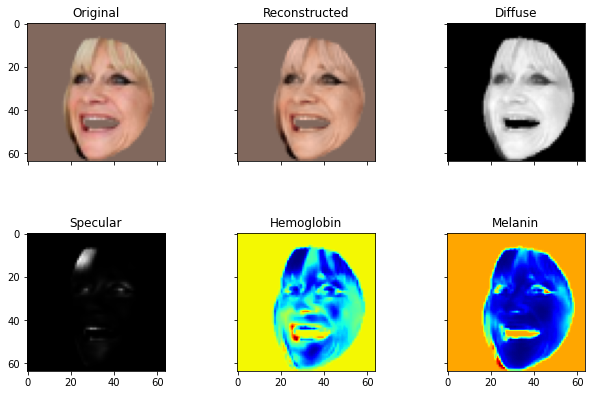

(64, 64, 3) [155.88623047 121.98730469 104.0871582 ] 38.96501470100722
(64, 64, 3) [156.16064453 121.90258789 103.76928711] 38.94841852040777
(64, 64, 1) [0.31423748] 0.40122205
(64, 64, 1) [0.0006881] 0.004324322
(64, 64, 1) [0.40431994] 0.14158645
(64, 64, 1) [0.35909536] 0.18801366


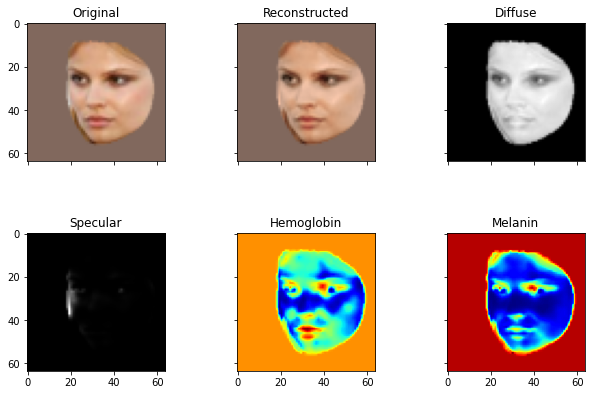

(64, 64, 3) [158.90869141 122.90307617 109.51538086] 41.84927809885281
(64, 64, 3) [159.45361328 123.39379883 108.41992188] 42.12468132622644
(64, 64, 1) [0.3459413] 0.3963685
(64, 64, 1) [0.00148814] 0.0048994813
(64, 64, 1) [0.36789027] 0.1658271
(64, 64, 1) [0.314983] 0.20954952


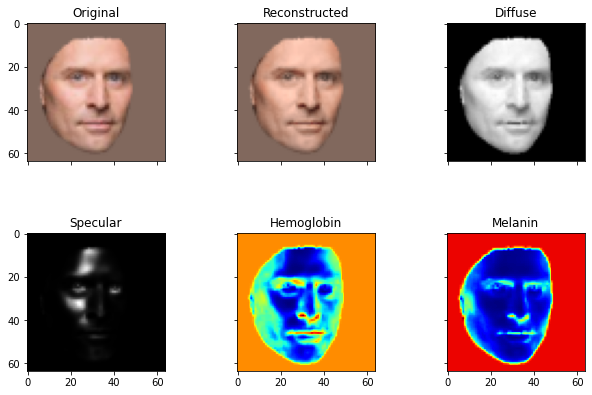

(64, 64, 3) [151.52978516 120.82373047 103.26123047] 46.58039891498112
(64, 64, 3) [151.74169922 120.86865234 102.90063477] 46.77357995415621
(64, 64, 1) [0.3308823] 0.4005585
(64, 64, 1) [8.5679436e-05] 0.0001985218
(64, 64, 1) [0.38514405] 0.14998999
(64, 64, 1) [0.33282202] 0.19796541


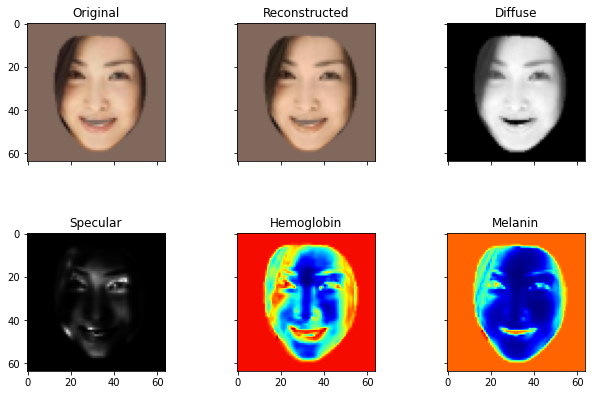

(64, 64, 3) [131.40649414  99.77514648  86.10131836] 47.43632572318074
(64, 64, 3) [131.45166016  99.6184082   86.09350586] 47.08878229591206
(64, 64, 1) [0.223231] 0.32002202
(64, 64, 1) [0.00970578] 0.035867594
(64, 64, 1) [0.4376049] 0.13540168
(64, 64, 1) [0.43236166] 0.1549196


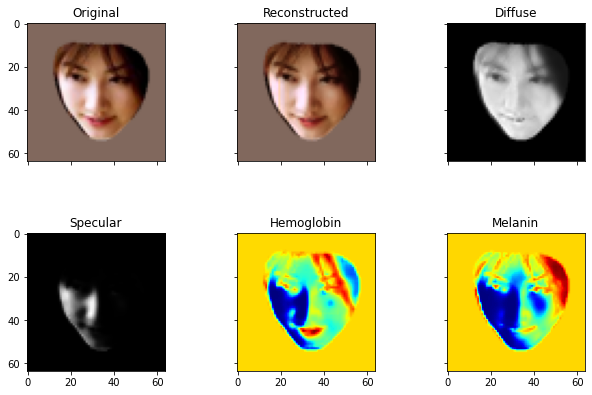

In [5]:
torch.cuda.empty_cache()

sample, mask, shade_pseudo = celebA_data.get_batch()
sample_img = torch.tensor(sample)
sample_img = sample_img.to(device)
bioFinder.eval()
output = bioFinder(sample_img)

mask_sample = np.reshape(mask, (64,64,64,1))

recons = output[0].cpu().detach().numpy()
diff   = output[2].cpu().detach().numpy()
spec   = output[3].cpu().detach().numpy()
fmel   = output[4].cpu().detach().numpy()
fhem   = output[5].cpu().detach().numpy()

mean_pixel = np.reshape(np.array([129.1863,104.7624,93.5940]), newshape=(1,1,3))

from mpl_toolkits.axes_grid1 import ImageGrid
for i in range(20):
    '''original'''
    img = np.transpose(sample[i], (1,2,0)) * mask_sample[i]
    img = np.clip(img + mean_pixel, 0, 255).astype(np.long)
    print(img.shape, np.mean(img, axis=(0,1)), np.std(img))
    # plt.imshow(img)
    # plt.show()

    mask = mask_sample[i] #> 0.8

    '''reconstructed'''
    # output_img = np.array([put.cpu().detach().numpy() for put in output[i]])
    output_img = np.transpose(recons[i], (1,2,0)) * mask
    output_img = np.clip(output_img + mean_pixel, 0, 255).astype(np.long)
    print(output_img.shape, np.mean(output_img, axis =(0,1)), np.std(output_img))
    # plt.imshow(output_img)
    # plt.show()

    '''diffuse'''
    diffs = np.transpose(diff[i], (1,2,0)) * mask
    print(diffs.shape, np.mean(diffs, axis =(0,1)), np.std(diffs))
    diffs = diffs / np.max(diffs)

    specs = np.transpose(spec[i], (1,2,0)) * mask
    print(specs.shape, np.mean(specs, axis =(0,1)), np.std(specs))
    specs = specs / np.max(specs)
    specs = np.concatenate((specs,specs,specs), axis = 2)

    fmels = np.transpose(fmel[i], (1,2,0)) * mask
    fmels = (fmels + 1)/2
    print(fmels.shape, np.mean(fmels, axis =(0,1)), np.std(fmels))

    fhems = np.transpose(fhem[i], (1,2,0)) * mask
    fhems = (fhems + 1)/2
    print(fhems.shape, np.mean(fhems, axis =(0,1)), np.std(fhems))


    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                    axes_pad=1,  # pad between axes in inch.
                    #cbar_mode="each",
                    #cbar_location="right",
                    #cbar_size="5%"
                    )

    for ax, cax, im, cmap_, text, vlim in zip(grid, grid.cbar_axes, [img, output_img, diffs, specs, fmels, fhems], 
                                    [None, None, 'gray', 'gray', 'jet', 'jet'], 
                                    ['Original', 'Reconstructed', 'Diffuse', 'Specular', 'Hemoglobin', 'Melanin'],
                                    [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]):
        # Iterating over the grid returns the Axes.
        pos = ax.imshow(im, cmap = cmap_)
        ax.set_title(text)
        # if(text == 'Hemoglobin' or text == 'Melanin'):
        #     cb = cax.colorbar(pos)
        #     cb.set_ticks((vlim[0], vlim[1]))

        #     grid.axes_llc.set_xticks([-2, 0, 2])
        #     grid.axes_llc.set_yticks([-2, 0, 2])

    plt.show()

In [7]:
torch.save(bioFinder.state_dict(), "models/new_model")